In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# This script also contains the functions linking observed tests, symptomatic/asymptomatic/toal diagnoses, 
# incidence, prevalence, screening and other model parameters
# Running it takes a little while because of all the symbolic algebra
%run -i test_diag_fun.py

# This script provides a function for calculating the likelihood of categorical data.
%run -i multinomial_pmf.py

# This script samples model parameters from prior distributions, following the method in england.ipynb.
%run -i sample_parameters.py

In [53]:
# now read in the local testing and diagnosis rates
import pandas as pd
from pandas import *
pd.options.mode.chained_assignment = None  # default='warn'

alldata = pd.read_csv('age_sex_region.csv')
alldata.index = range(len(alldata))
print alldata[['AreaName','tests.male.15-19','positives.male.15-19', 'population.male.15-19']][:10]

# la: Local Authority (Upper Tier)
# gor: Government Office Region
# phec: Public Health England Region
# pher: Public Health England Centre

               AreaName  tests.male.15-19  positives.male.15-19  \
0                London           20573.0                2151.0   
1         West Midlands           11532.0                1314.0   
2         East Midlands           11619.0                1146.0   
3       East of England           11156.0                 988.0   
4            North East            7158.0                 766.0   
5  Yorkshire and Humber           11965.0                1656.0   
6            North West           17530.0                1981.0   
7            South West           12276.0                1216.0   
8            South East           17540.0                1511.0   
9                London           22333.0                2172.0   

   population.male.15-19  
0               240789.0  
1               181914.0  
2               145232.0  
3               187117.0  
4                79797.0  
5               167478.0  
6               218359.0  
7               163332.0  
8               266

In [5]:
# NB random state (rs) is set in sample_parameters.py, above.

# set up arrays to store, for each LA: 
test_sample_m = empty([n_sample, len(alldata)]) # testing rate
test_sample_f = empty([n_sample, len(alldata)])
diag_sample_m = empty([n_sample, len(alldata)]) # observed diagnosis rate
diag_sample_f = empty([n_sample, len(alldata)])
diag_m_la = empty([n_sample, len(alldata)]) # predicted diagnosis rate
diag_f_la = empty([n_sample, len(alldata)])

for i in xrange(len(alldata.index)):
    
    #####
    # men
    #####
    # sample for the testing rate, per sexually active 15-24-year-old
    test_sample_m[:,i] = rs.gamma(alldata['tests.male.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.male.15-19'][i] + alldata['population.male.20-24'][i], 
                        p_active_m_16_24, size=n_sample)
    diag_sample_m[:,i] = rs.gamma(alldata['positives.male.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.male.15-19'][i] + alldata['population.male.20-24'][i], 
                        p_active_m_16_24, size=n_sample)
        
    #####
    # women
    #####
    # sample for the testing rate, per sexually active 15-24-year-old
    test_sample_f[:,i] = rs.gamma(alldata['tests.female.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.female.15-19'][i] + alldata['population.female.20-24'][i], 
                        p_active_f_16_24, size=n_sample)
    diag_sample_f[:,i] = rs.gamma(alldata['positives.female.total'][i],1,size = n_sample)/ \
        rs.binomial(alldata['population.female.15-19'][i] + alldata['population.female.20-24'][i], 
                        p_active_f_16_24, size=n_sample)

In [6]:
# set up arrays to store, for each LA: 
scr_m_la = empty([n_sample, len(alldata)]) # screening (estimated for each LA separately)
scr_f_la = empty([n_sample, len(alldata)])
inc_m_la = empty([n_sample, len(alldata)])  # estimated incidence
inc_f_la = empty([n_sample, len(alldata)])
prev_m_la = empty([n_sample, len(alldata)]) # estimated prevalence
prev_f_la = empty([n_sample, len(alldata)])

for i in xrange(len(alldata.index)):
    
    # keep track of whether stuff is happening
    if fmod(i,10)==0:
        print i, alldata.AreaName[i], alldata.year[i]
    
    #####
    # men
    #####
        
    # screening and diagnosis rates
    for j in xrange(n_sample):
        # local screening and incidence, given local testing and diagnoses
        [inc_m_la[j,i], scr_m_la[j,i]] = fsolve(lambda x: test_diag_fun(concatenate([
                        x, array([
                                1-p_asymp_m[j], # proportion of incident infections which are symptomatic
                                sc_m[j], # rate of self-clear 
                                att_symp[j],
                                p_true_pos_m[j], 
                                p_false_pos_m[j]
                            ])])) - array([test_sample_m[j,i],diag_sample_m[j,i]]), [0.09, 0.25])
        # local prevalence, calculated from local screening and incidence
        prev_m_la[j,i] = dyn_fun(
            inc_m_la[j,i]*p_asymp_m[j], 
            sc_m[j] + scr_m_la[j,i]*p_true_pos_m[j], 
            inc_m_la[j,i]*(1-p_asymp_m[j]), 
            scr_m_la[j,i]*p_true_pos_m[j] + att_symp[j]*p_true_pos_m[j]
        )
    
    #####
    # women
    #####

    # screening and diagnosis rates
    diag_f_la[:,i] = zeros(n_sample)
    for j in xrange(n_sample):
        # local screening and incidence, given local testing and diagnoses
        [inc_f_la[j,i], scr_f_la[j,i]] = fsolve(lambda x: test_diag_fun(concatenate([
                        x, array([
                                1-p_asymp_f[j], # proportion of incident infections which are symptomatic
                                sc_f[j], # rate of self-clear 
                                att_symp[j],
                                p_true_pos_f[j], 
                                p_false_pos_f[j]
                            ])])) - array([test_sample_f[j,i],diag_sample_f[j,i]]), [0.09, 0.25])
        # local prevalence, calculated from local screening and incidence
        prev_f_la[j,i] = dyn_fun(
            inc_f_la[j,i]*p_asymp_f[j], 
            sc_f[j] + scr_f_la[j,i]*p_true_pos_f[j], 
            inc_f_la[j,i]*(1-p_asymp_f[j]), 
            scr_f_la[j,i]*p_true_pos_f[j] + att_symp[j]*p_true_pos_f[j]
        )


0 London 2016
10 West Midlands 2015
20 East Midlands 2014
30 East of England 2013
40 North East 2012


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/optimize/minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [54]:
pid_data = pd.read_csv('PID_byarea.csv')
pid_data.index = range(len(pid_data))
pid_data = pid_data[pid_data.Sex == 'Female'] 
print pid_data['Value']


0       216.402399
1       210.656247
2       250.900375
3       189.806917
4       260.011626
5       201.023260
6       164.486114
7       211.959404
8       208.542597
9       256.858884
10      364.298725
11      135.078969
12      192.507604
13      226.303194
14      332.762417
15      262.822555
16      198.712144
17      167.840453
18      264.026403
19      408.027459
20      234.888819
21      270.392068
22      158.125726
23      106.708402
24      294.671204
25      273.407206
26      144.207659
27      286.717700
28      168.051240
29      195.486049
           ...    
1428    223.878210
1429    152.773165
1430     86.625087
1431    178.129846
1432    150.169546
1433    245.541000
1434    259.109431
1435    240.470749
1436    211.515081
1437    162.887294
1438    216.479502
1439    192.052002
1440    223.247444
1441    193.559431
1442    269.048916
1443    239.851543
1444    237.140481
1445    229.758952
1446    169.759022
1447    204.503523
1448    218.418136
1449    285.

In [55]:
alldata = alldata.merge(pid_data, how='inner', left_on = list(['AreaCode', 'Timeperiod']), right_on = list(['AreaCode', 'Timeperiod']))

In [56]:
list(alldata)

['AreaCode',
 'AreaName_x',
 'year',
 'Timeperiod',
 'tests.male.15-19',
 'tests.male.20-24',
 'tests.male.total',
 'tests.female.15-19',
 'tests.female.20-24',
 'tests.female.total',
 'tests.total.15-19',
 'tests.total.20-24',
 'tests.total',
 'positives.male.15-19',
 'positives.male.20-24',
 'positives.male.total',
 'positives.female.15-19',
 'positives.female.20-24',
 'positives.female.total',
 'positives.total.15-19',
 'positives.total.20-24',
 'positives.total',
 'population.male.15-19',
 'population.male.20-24',
 'population.female.15-19',
 'population.female.20-24',
 'population.total',
 'Unnamed: 0',
 'IndicatorID',
 'IndicatorName',
 'ParentCode',
 'ParentName',
 'AreaName_y',
 'AreaType',
 'Sex',
 'Age',
 'CategoryType',
 'Category',
 'Value',
 'LowerCI95.0limit',
 'UpperCI95.0limit',
 'LowerCI99.8limit',
 'UpperCI99.8limit',
 'Count',
 'Denominator',
 'Valuenote',
 'RecentTrend',
 'ComparedtoEnglandvalueorpercentiles',
 'Comparedtosubnationalparentvalueorpercentiles',
 'Time

In [57]:
print alldata
shape(prev_f_la)

     AreaCode            AreaName_x  year Timeperiod  tests.male.15-19  \
0   E12000007                London  2016    2015/16           20573.0   
1   E12000005         West Midlands  2016    2015/16           11532.0   
2   E12000004         East Midlands  2016    2015/16           11619.0   
3   E12000006       East of England  2016    2015/16           11156.0   
4   E12000001            North East  2016    2015/16            7158.0   
5   E12000003  Yorkshire and Humber  2016    2015/16           11965.0   
6   E12000002            North West  2016    2015/16           17530.0   
7   E12000009            South West  2016    2015/16           12276.0   
8   E12000008            South East  2016    2015/16           17540.0   
9   E12000007                London  2015    2014/15           22333.0   
10  E12000005         West Midlands  2015    2014/15           14278.0   
11  E12000004         East Midlands  2015    2014/15           13763.0   
12  E12000006       East of England  2

(10000, 45)

(0.5, 0.7)

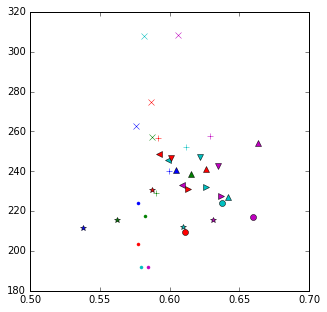

In [95]:

fig = plt.figure(figsize = (5,5))
ax2 = fig.add_subplot(111)

# ax2.errorbar(
#     percentile(prev_f_la/(inc_f_la*(1-prev_f_la)), 50, 0)*logical_not(array(isnan(alldata['tests.male.15-19']))), 
#     alldata['Value'],
#     xerr=squeeze(
#         array([[percentile(prev_f_la/(inc_f_la*(1-prev_f_la)),50, 0) - percentile(prev_f_la/(inc_f_la*(1-prev_f_la)), 2.5, 0)], 
#             [percentile(prev_f_la/(inc_f_la*(1-prev_f_la)), 97.5, 0) - percentile(prev_f_la/(inc_f_la*(1-prev_f_la)),50, 0)]])),
#     linestyle='None', color='r', alpha=0.2)

sym_dict = {'London':'.', 'West Midlands':'^', 'East Midlands':'v', 'East of England':'o', 'North East':'*', \
            'Yorkshire and Humber':'+', 'North West':'x', 'South West':'<', 'South East':'>'}
col_dict = {2012:'b', 2013:'g', 2014:'r', 2015:'c', 2016:'m'}

for i in range(len(alldata.Value)):
    ax2.plot(
        percentile(prev_f_la/(inc_f_la*(1-prev_f_la)), 50, 0)[i]*logical_not(array(isnan(alldata['tests.male.15-19'])))[i], 
        array(alldata['Value'])[i],
        marker = sym_dict[array(alldata['AreaName_x'])[i]],
        color = col_dict[array(alldata['year'])[i]]
        )

ax2.set_xlim([0.5, 0.7])#; ax2.set_ylim([0,0.08])
#ax2.set_xlabel('Prevalence in sexually active women 15-24')
#ax2.set_ylabel('Positivity')
#ax2.set_title('Sexually active women 15-24')


In [93]:
col_dict['2016']

'm'

In [80]:
al = prev_f_la/(inc_f_la*(1-prev_f_la))
print(shape(al))
print shape(transpose(tile(array(al[:,0],ndmin=2),[151,1])))
print percentile(array(al[:,0]), 50)

(10000, 151)
(10000, 151)
0.562783848254


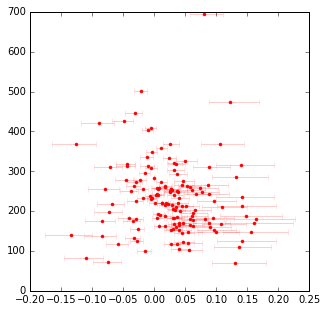

In [79]:
al = prev_f_la/(inc_f_la*(1-prev_f_la))
al_diff = al - transpose(tile(array(al[:,0],ndmin=2),[151,1]))

fig = plt.figure(figsize = (5,5))
ax2 = fig.add_subplot(111)

ax2.errorbar(
    percentile(al_diff, 50, 0), 
    alldata['Value'],
    xerr=squeeze(
        array([[percentile(al_diff,50, 0) - percentile(al_diff, 2.5, 0)], 
            [percentile(al_diff, 97.5, 0) - percentile(al_diff,50, 0)]])),
    linestyle='None', color='r', alpha=0.2)
ax2.plot(
    percentile(al_diff, 50, 0), 
    alldata['Value'],
    '.r')

#ax2.set_xlim([0,0.08])#; ax2.set_ylim([0,0.08])
#ax2.set_xlabel('Prevalence in sexually active women 15-24')
#ax2.set_ylabel('Positivity')
#ax2.set_title('Sexually active women 15-24')


(0, 0.1)

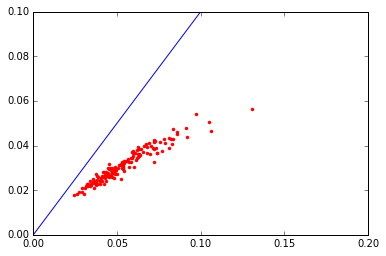

In [54]:
plt.plot(percentile((inc_f_la*(1-prev_f_la)), 50, 0), percentile(prev_f_la, 50, 0), '.r')
plt.plot([0,1],[0,1])
plt.xlim([0,0.2])
plt.ylim([0,0.1])

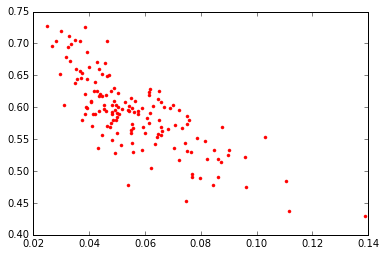

In [56]:
plt.plot(percentile(inc_f_la, 50, 0), percentile(prev_f_la/(inc_f_la*(1-prev_f_la)), 50, 0), '.r')

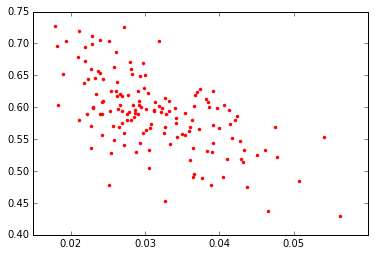

In [57]:
plt.plot(percentile(prev_f_la, 50, 0), percentile(prev_f_la/(inc_f_la*(1-prev_f_la)), 50, 0), '.r')